In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset

from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

# TASK 1
Constructing a dataset with a subset of languages that are roman-script based.

I have created one file each for a language and  with one sentence per line

In [ ]:
df = load_dataset("qanastek/MASSIVE")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


MASSIVE.py:   0%|          | 0.00/32.3k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/34.1k [00:00<?, ?B/s]

The repository for qanastek/MASSIVE contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/qanastek/MASSIVE.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
lang_locales = ['af-ZA', 'da-DK', 'de-DE', 'en-US', 'es-ES', 'fr-FR', 'fi-FI', 'hu-HU',
                'is-IS', 'it-IT', 'jv-ID', 'lv-LV', 'ms-MY', 'nb-NO', 'nl-NL', 'pl-PL',
                'pt-PT', 'ro-RO', 'ru-RU', 'sl-SL', 'sv-SE', 'sq-AL', 'sw-KE', 'tl-PH',
                'tr-TR', 'vi-VN', 'cy-GB']


In [ ]:
data_train = df['train']

In [ ]:
data=pd.DataFrame({'locale': data_train['locale'],'utt': data_train['utt'], 'partition': data_train['partition']})

data_test=df['test']
test_data=pd.DataFrame({'locale': data_test['locale'],'utt': data_test['utt'], 'partition': data_test['partition']})

data_val=df['validation']
val_data=pd.DataFrame({'locale': data_val['locale'], 'utt': data_val['utt'],'partition': data_val['partition']})

data=pd.concat((data, test_data))
data=pd.concat((data, val_data))

In [ ]:
os.makedirs("languages")

In [ ]:
data=data.loc[data['locale'].isin(lang_locales)]
for value in data['locale'].unique():
  subset=data.loc[data['locale']==value]
  subset.to_csv('languages/%s.tsv'%value, sep='\t', index=False)



# Task 2


#### We create a dataset that stores the combined data from 27 .tsv files created during the first task, each containing language data for different locales.

In [ ]:
data=None
for lang in lang_locales:
  subset=pd.read_csv('languages/%s.tsv'%lang, sep='\t')
  if data is None:
    data=subset
  else:
    data=pd.concat((data, subset))

train_data=data.loc[data['partition']=='train', ['locale', 'utt']]
test_data=data.loc[data['partition']=='test', ['locale', 'utt']]
val_data=data.loc[data['partition']=='dev', ['locale', 'utt']]

In [ ]:
X_train, y_train=train_data['utt'], train_data['locale']
X_test, y_test=test_data['utt'], test_data['locale']
X_val, y_val=val_data['utt'], val_data['locale']


## Hyperparameter tuning
 #### We use grid search for different values of alpha for a Multinomial Naive Bayes model, using TfidfVectorizer for feature extraction. It identifies the best alpha value that maximizes the validation accuracy. It then refits the model with the best value of alpha

In [ ]:
best_score = 0
best_alpha=2
for i in np.linspace(0.01, 1, 20):
  A = i
  model = Pipeline([('tfidf', TfidfVectorizer()), ('nb', MultinomialNB(alpha = A))])
  model.fit(X_train, y_train)
  score=model.score(X_val, y_val)
  if score > best_score:
    best_score = score
    best_alpha = A

model = Pipeline([('tfidf', TfidfVectorizer()), ('nb', MultinomialNB(alpha=best_alpha))])
model.fit(X_train, y_train)
print('Best Alpha: %.3f'%best_alpha)

Best Alpha: 0.114


#### This function evaluates the performance of a model bby reporting four metrics, namely accuracy, precision, recall and f1 score

In [ ]:
def model_performance(model, X, y):
    y_pred = model.predict(X)
    print('Accuracy:', round(accuracy_score(y, y_pred)*100,4))
    print('Precision:', round(precision_score(y, y_pred, average="macro")*100,4))
    print('Recall:', round(recall_score(y, y_pred, average="macro")*100,4))
    print('F1-Score:', round(f1_score(y, y_pred, average="macro")*100, 4))


In [ ]:
print("Performance on Training set:")
model_performance(model, X_train, y_train)

print("\nPerformance on Validation set:")
model_performance(model, X_val, y_val)

print("\nPerformance on Test set:")
model_performance(model, X_test, y_test)

Performance on Training set:
Accuracy: 99.3232
Precision: 99.3253
Recall: 99.3232
F1-Score: 99.3235

Performance on Validation set:
Accuracy: 98.5061
Precision: 98.5364
Recall: 98.5061
F1-Score: 98.5137

Performance on Test set:
Accuracy: 98.4744
Precision: 98.5259
Recall: 98.4744
F1-Score: 98.4871


# TASK 3

#### A dictionary named continents is used to map the locale codes to the continent name. Then, the locale names are replaced with the continent names in y_val, y_test and y_train..

In [ ]:
continents = {'af-ZA': 'Africa', 'da-DK': 'Europe', 'de-DE': 'Europe', 'en-US': 'North America','es-ES': 'Europe',
'fr-FR': 'Europe', 'fi-FI': 'Europe', 'hu-HU': 'Europe','is-IS': 'Europe', 'it-IT': 'Europe', 'jv-ID': 'Asia',
'lv-LV': 'Europe', 'ms-MY': 'Asia', 'nb-NO': 'Europe', 'nl-NL': 'Europe', 'pl-PL': 'Europe', 'pt-PT': 'Europe',
'ro-RO': 'Europe', 'ru-RU': 'Europe', 'sl-SL': 'Europe','sv-SE': 'Europe', 'sq-AL': 'Europe', 'sw-KE': 'Africa',
'tl-PH': 'Asia', 'tr-TR': 'Asia', 'vi-VN': 'Asia', 'cy-GB': 'Europe'}

df1 = [y_train, y_val, y_test]
df2 = []

for i in df1:
    y = []
    for locale in i:
        if locale in continents:
            y.append(continents[locale])
        else:
            y.append(None)
    df2.append(pd.Series(y))

y_train, y_val, y_test = df2

PCA transformation is done because it takes a sparse matrix and gives a dense matrix of the most important features. Since, QDA and LDA accept only dense matrices, we do PCA transormation before feeding the data into the Regularized Discriminant Analysis (RDA) model

In [ ]:
trans=Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=10000)),
                      ('pca', PCA(n_components=500))])
X_train=trans.fit_transform(X_train, y_train)
X_test=trans.transform(X_test)
X_val=trans.transform(X_val)

#### This class combines Linear Discriminant Analysis and Quadratic Discriminant Analysis models using a weighted average. A lambda parameter controls the balance between LDA and QDA. Both models are trained on the same data and class probabilities is calculated using both models. Then we returns predictions based on the weighted average of the two, using lambda parameter to adjust the mix between LDA and QDA.

In [ ]:
class RDA:
    def __init__(self, lambda_param=0.5):
        self.lambda_param = lambda_param
        self.lda = LinearDiscriminantAnalysis()
        self.qda = QuadraticDiscriminantAnalysis()

    def fit(self, X, y):
        self.lda.fit(X, y)
        self.qda.fit(X, y)

    def predict(self, X):
        lda_pred = self.lda.predict_proba(X)
        qda_pred = self.qda.predict_proba(X)
        return (self.lambda_param * lda_pred + (1 - self.lambda_param) * qda_pred).argmax(axis=1)

We evaluate the RDA model by testing different weights (lambda values) between Linear and Quadratic Discriminant Analysis. We choose 20 linearly spaced weights between 0 and 1

In [ ]:
accuracies=[]
rda_model=RDA(lambda_param=0.5)
rda_model.fit(X_train, y_train)
lda_pred = rda_model.lda.predict_proba(X_val)
qda_pred = rda_model.qda.predict_proba(X_val)


for param in np.linspace(0, 1, 20):
  proba=(param * lda_pred + (1 - param) * qda_pred)
  predictions=rda_model.lda.classes_[proba.argmax(axis=1)]
  accuracies.append((predictions==y_val).mean()*100)

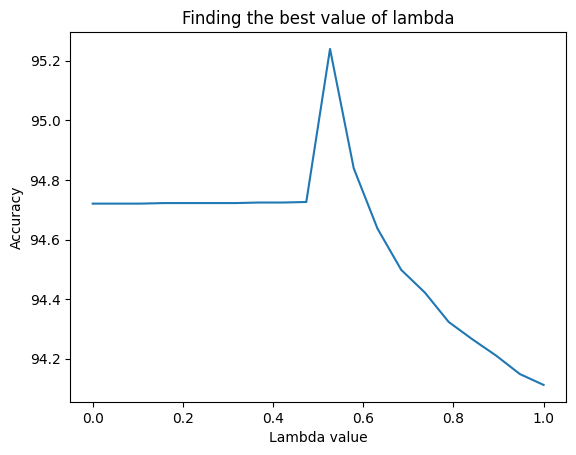

In [ ]:
plt.plot(np.linspace(0,1,20), accuracies)
plt.title("Finding the best value of lambda")
plt.xlabel("Lambda value")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
print("The best value of lambda is:", round(np.linspace(0,1,20)[np.argmax(accuracies)],4))

The best value of lambda is: 0.5263


#### Lambda value is used to balance the weightage given to QDA and LDA.

#### The above graph visualises the accuracy of RDA with respect to the lambda values.

#### The best value of lambda is 0.5263